In [6]:

import os
import sys
import argparse
import math
import numpy as np
import timeit
import torch
import torch.utils.data as data_utils
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
from sklearn.model_selection import train_test_split
sys.path.append("/home/jovyan/20230406_ArticleClassifier/ArticleClassifier")

import src.general.global_variables as gv
from src.general.utils import cc_path

sys.path.append(gv.PROJECT_PATH)


sys.path.append(
    os.path.abspath(os.path.join(os.path.dirname('data_loader.py'), os.path.pardir)))
from src.data.data_loader import DataLoader

# def load_data(data_path, max_length, vocab_size, batch_size=64):
#     X_trn, Y_trn, X_tst, Y_tst, vocabulary, vocabulary_inv = data_helpers.load_data(data_path, max_length=max_length,
#                                                                                     vocab_size=vocab_size)
#     Y_trn = Y_trn[0:].toarray()
#     Y_trn = np.insert(Y_trn, 101, 0, axis=1)
#     Y_trn = np.insert(Y_trn, 102, 0, axis=1)
#     Y_tst = Y_tst[0:].toarray()
#
#     train_data = data_utils.TensorDataset(torch.from_numpy(X_trn).type(torch.LongTensor),
#                                           torch.from_numpy(Y_trn).type(torch.LongTensor))
#     test_data = data_utils.TensorDataset(torch.from_numpy(X_tst).type(torch.LongTensor),
#                                          torch.from_numpy(Y_tst).type(torch.LongTensor))
#     train_loader = data_utils.DataLoader(train_data, batch_size, drop_last=False, shuffle=True)
#     test_loader = data_utils.DataLoader(test_data, batch_size, drop_last=False)
#     return train_loader, test_loader, vocabulary, X_tst, Y_tst, X_trn, Y_trn

def precision_k(pred, label, k=[1, 3, 5]):
    batch_size = pred.shape[0]

    precision = []
    for _k in k:
        p = 0
        for i in range(batch_size):
            p += label[i, pred[i, :_k]].mean()
        precision.append(p * 100 / batch_size)

    return precision


def ndcg_k(pred, label, k=[1, 3, 5]):
    batch_size = pred.shape[0]

    ndcg = []
    for _k in k:
        score = 0
        rank = np.log2(np.arange(2, 2 + _k))
        for i in range(batch_size):
            l = label[i, pred[i, :_k]]
            n = l.sum()
            if (n == 0):
                continue

            dcg = (l / rank).sum()
            label_count = label[i].sum()
            norm = 1 / np.log2(np.arange(2, 2 + np.min((_k, label_count))))
            norm = norm.sum()
            score += dcg / norm

        ndcg.append(score * 100 / batch_size)

    return ndcg


# input data_path
# data_path = '/data/rcv1_raw_text.p'
sequence_length = 500
batch_size = 64

def load_glove_embeddings(path, embedding_dim):
    """Loading the glove embeddings"""
    with open(path, 'r', encoding='utf-8') as f:
        lines = f.readlines()
        embeddings = np.zeros((len(lines)+1, embedding_dim))
        word_idx_dict = {}
        for index, line in tqdm(enumerate(lines), desc='vocab building: '):
            values = line.split()
            word = values[0]
            word_idx_dict[word] = index + 1
            if index:
                vector = np.array(values[1:], dtype='float32')
                if vector.shape[-1] != embedding_dim:
                    raise Exception('Dimension not matching.')
                embeddings[index] = vector

    return torch.from_numpy(embeddings).float(), word_idx_dict




# load glove
pretrain = 'glove'
embedding_dim = 256
# input word2vec file path
file_path = cc_path(f'data/processed/canary/word_embeddings_{pretrain}_2023-04-11.csv')
embedding_weights, word_idx_dict = load_glove_embeddings(file_path, embedding_dim)


vocab building: : 456009it [00:51, 8811.09it/s] 


In [7]:
word_idx_dict

{'ldlpcsk9': 1,
 'gapppi': 2,
 'mtl': 3,
 'cables2tom': 4,
 'bottoms': 5,
 'aor098': 6,
 '018954': 7,
 'count': 8,
 'trimeresurus': 9,
 'cd40loverexpressing': 10,
 'kindia': 11,
 'þjq1': 12,
 'nct00894569': 13,
 'ecic': 14,
 'inch': 15,
 '25monthold': 16,
 'patientmethodsa': 17,
 'carbacholstimulated': 18,
 '6105': 19,
 'postdiapause': 20,
 'hvlpfc': 21,
 '12478': 22,
 'viruscontaining': 23,
 '06001718': 24,
 'rearwardfacing': 25,
 'pipj': 26,
 'matra': 27,
 'lsn': 28,
 'salvati': 29,
 'or2s2': 30,
 'distal': 31,
 'chloriderich': 32,
 'b0034': 33,
 '7189': 34,
 'apelin13': 35,
 'ci096': 36,
 'rum2bac': 37,
 'groupslow': 38,
 'herpesviridae': 39,
 '12377072': 40,
 'gravitating': 41,
 'lees': 42,
 'osteomalacia': 43,
 'g2032r': 44,
 'dualleucine': 45,
 'uveitic': 46,
 'heartwood': 47,
 'echocardiograms': 48,
 'hladrcd11chladr': 49,
 'intergranular': 50,
 'leftpapvc': 51,
 'leukocytemimetic': 52,
 'stanisław': 53,
 'cu5ce5w9tii': 54,
 '8071': 55,
 'pt790m': 56,
 'sulfhydrated': 57,
 'inca

In [8]:
print('-' * 50)
print('Loading data...');
start_time = timeit.default_timer()
# load all the data
loc_dict = {
    'processed_csv': cc_path('data/processed/canary/articles_cleaned.csv'),
    'abstract_embeddings': cc_path('data/processed/canary/embeddings_fasttext_20230410.csv'),
    'keyword_network': cc_path('data/processed/canary/keyword_network.pickle'),
    'author_network': cc_path('data/processed/canary/author_network.pickle')
}
data_loader = DataLoader(loc_dict)
processed_df = data_loader.load_processed_csv()

embedding_df = data_loader.load_embeddings_csv()
embedding_df['pui'] = embedding_df['pui'].astype(str)
processed_df['pui'] = processed_df['pui'].astype(str)

embedding_df[embedding_df.columns.difference(['pui'])] = \
    (embedding_df[embedding_df.columns.difference(['pui'])] -
     embedding_df[embedding_df.columns.difference(['pui'])].mean()) / \
    embedding_df[embedding_df.columns.difference(['pui'])].std()

label_columns = processed_df.loc[:, ~processed_df.columns.isin(
    ['file_name', 'title', 'keywords', 'abstract', 'abstract_2', 'authors', 'organization', 'chemicals',
     'num_refs', 'date-delivered', 'labels_m', 'labels_a', 'Unnamed 0:'])]

label_columns = label_columns[label_columns.pui.isin(embedding_df.pui)].reset_index(drop=True)
abstracts_df = processed_df.loc[processed_df.pui.isin(label_columns.pui), ['pui', 'abstract']].reset_index(drop=True)

train_indices, test_indices = train_test_split(range(len(label_columns)), test_size=0.2, random_state=0)



--------------------------------------------------
Loading data...


In [9]:
abstracts_df['abstract'] = abstracts_df['abstract'].apply(lambda x: [int(word_idx_dict[word]) for word in x.split(' ')])


<Axes: >

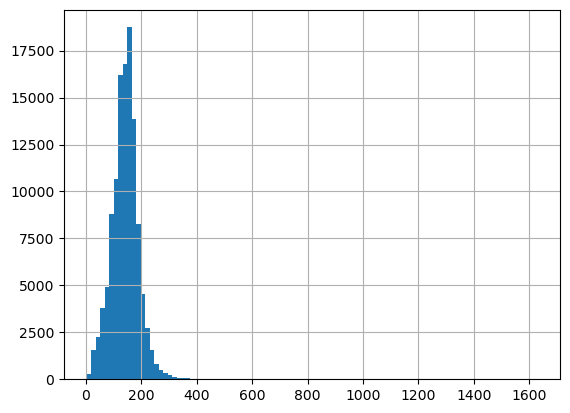

In [10]:
abstracts_df['abstract'].apply(len).hist(bins=100)

In [11]:
set_width = 200
abstracts_df['abstract'] = abstracts_df['abstract'].apply(lambda x: x + [0] * (set_width - len(x)) if len(x) <= set_width else x[:set_width])


In [12]:
np.array(abstracts_df.loc[train_indices, 'abstract'].to_list(), dtype=int)

array([[222834,   4890, 255464, ...,      0,      0,      0],
       [395526, 425546, 189352, ...,      0,      0,      0],
       [451371, 116311, 359800, ...,      0,      0,      0],
       ...,
       [216705,  69118, 152347, ...,      0,      0,      0],
       [417561, 201022, 206759, ...,      0,      0,      0],
       [359070,  23900, 174650, ...,      0,      0,      0]])

In [13]:
X_trn = np.array(abstracts_df.loc[train_indices, 'abstract'].to_list(), dtype=int)
X_tst = np.array(abstracts_df.loc[test_indices, 'abstract'].to_list(), dtype=int)


Y_trn = label_columns.loc[train_indices, label_columns.columns.difference(['pui'])].to_numpy(dtype=int)
Y_tst = label_columns.loc[test_indices, label_columns.columns.difference(['pui'])].to_numpy(dtype=int)



In [15]:
batch_size=64
train_data = data_utils.TensorDataset(torch.from_numpy(X_trn).type(torch.LongTensor),
                                      torch.from_numpy(Y_trn).type(torch.LongTensor))
test_data = data_utils.TensorDataset(torch.from_numpy(X_tst).type(torch.LongTensor),
                                     torch.from_numpy(Y_tst).type(torch.LongTensor))
train_loader = data_utils.DataLoader(train_data, batch_size, drop_last=False, shuffle=True)
test_loader = data_utils.DataLoader(test_data, batch_size, drop_last=False)


# train_loader, test_loader, vocabulary, X_tst, Y_tst, X_trn, Y_trn = load_data(data_path, sequence_length, vocab_size,
#                                                                               batch_size)
print('Process time %.3f (secs)\n' % (timeit.default_timer() - start_time))




vocab_size = embedding_weights.size(0)

# create Network structure

Process time 37.081 (secs)



In [16]:

class BasicModule(nn.Module):
    def __init__(self):
        super(BasicModule, self).__init__()
        self.model_name = str(type(self))

    def load(self, path):
        self.load_state_dict(torch.load(path))

    def save(self, path=None):
        if path is None:
            raise ValueError('Please specify the saving road!!!')
        torch.save(self.state_dict(), path)
        return path


# In[9]:


def get_embedding_layer(embedding_weights):
    word_embeddings = nn.Embedding(num_embeddings=embedding_weights.size(0), embedding_dim=embedding_weights.size(1))
    word_embeddings.weight.data.copy_(embedding_weights)
    word_embeddings.weight.requires_grad = False  # not train
    return word_embeddings


class Hybrid_XML(BasicModule):
    def __init__(self, num_labels=3714, vocab_size=30001, embedding_size=300, embedding_weights=None,
                 max_seq=300, hidden_size=256, d_a=256, label_emb=None):
        super(Hybrid_XML, self).__init__()
        self.embedding_size = embedding_size
        self.num_labels = num_labels
        self.max_seq = max_seq
        self.hidden_size = hidden_size

        if embedding_weights is None:
            self.word_embeddings = nn.Embedding(vocab_size, embedding_size)
        else:
            self.word_embeddings = get_embedding_layer(embedding_weights)

        self.lstm = nn.LSTM(input_size=self.embedding_size, hidden_size=self.hidden_size, num_layers=1,
                            batch_first=True, bidirectional=True)

        # interaction-attention layer
        self.key_layer = torch.nn.Linear(2 * self.hidden_size, self.hidden_size)
        self.query_layer = torch.nn.Linear(self.hidden_size, self.hidden_size)

        # self-attn layer
        self.linear_first = torch.nn.Linear(2 * self.hidden_size, d_a)
        self.linear_second = torch.nn.Linear(d_a, self.num_labels)

        # weight adaptive layer
        self.linear_weight1 = torch.nn.Linear(2 * self.hidden_size, 1)
        self.linear_weight2 = torch.nn.Linear(2 * self.hidden_size, 1)

        # shared for all attention component
        self.linear_final = torch.nn.Linear(2 * self.hidden_size, self.hidden_size)
        self.output_layer = torch.nn.Linear(self.hidden_size, 1)

        label_embedding = torch.FloatTensor(self.num_labels, self.hidden_size)
        if label_emb is None:
            nn.init.xavier_normal_(label_embedding)
        else:
            label_embedding.copy_(label_emb)
        self.label_embedding = nn.Parameter(label_embedding, requires_grad=False)

    def init_hidden(self, batch_size):
        if torch.cuda.is_available():
            return (
            torch.zeros(2, batch_size, self.hidden_size).cuda(), torch.zeros(2, batch_size, self.hidden_size).cuda())
        else:
            return (torch.zeros(2, batch_size, self.hidden_size), torch.zeros(2, batch_size, self.hidden_size))

    def forward(self, x, embedding_generation=False):

        emb = self.word_embeddings(x)

        hidden_state = self.init_hidden(emb.size(0))
        output, hidden_state = self.lstm(emb, hidden_state)  # [batch,seq,2*hidden]

        # get attn_key
        attn_key = self.key_layer(output)  # [batch,seq,hidden]
        attn_key = attn_key.transpose(1, 2)  # [batch,hidden,seq]
        # get attn_query
        label_emb = self.label_embedding.expand(
            (attn_key.size(0), self.label_embedding.size(0), self.label_embedding.size(1)))  # [batch,L,label_emb]
        label_emb = self.query_layer(label_emb)  # [batch,L,label_emb]

        # attention
        similarity = torch.bmm(label_emb, attn_key)  # [batch,L,seq]
        similarity = F.softmax(similarity, dim=2)
        print(similarity.size(), output.size())
        out1 = torch.bmm(similarity, output)  # [batch,L,label_emb]

        # self-attn output
        self_attn = torch.tanh(self.linear_first(output))  # [batch,seq,d_a]
        self_attn = self.linear_second(self_attn)  # [batch,seq,L]
        self_attn = F.softmax(self_attn, dim=1)
        self_attn = self_attn.transpose(1, 2)  # [batch,L,seq]
        out2 = torch.bmm(self_attn, output)  # [batch,L,hidden]

        factor1 = torch.sigmoid(self.linear_weight1(out1))
        factor2 = torch.sigmoid(self.linear_weight2(out2))
        factor1 = factor1 / (factor1 + factor2)
        factor2 = 1 - factor1

        out = factor1 * out1 + factor2 * out2
        
        if embedding_generation:
            return out
        
        out = F.relu(self.linear_final(out))
        out = torch.sigmoid(self.output_layer(out).squeeze(-1))  # [batch,L]

        return out


In [17]:

label_emb = np.zeros((52, 52))
label_index_mapping = {}
with open(cc_path(f'notebooks/label_embedding_test.txt')) as f:
    for index, i in enumerate(f.readlines()):
        if index == 0:
            continue
        i = i.rstrip('\n')
        n = i.split(',')[0]
        content = i.split(',')[1].split(' ')
        label_index_mapping[index-1] = n
        label_emb[index-1] = [float(value) for value in content]



label_emb = torch.from_numpy(label_emb).float()




In [18]:
model = Hybrid_XML(num_labels=52, vocab_size=len(word_idx_dict), embedding_size=256, embedding_weights=embedding_weights,
                   max_seq=200, hidden_size=52, d_a=256, label_emb=label_emb)


In [19]:
print(model)

Hybrid_XML(
  (word_embeddings): Embedding(456010, 256)
  (lstm): LSTM(256, 52, batch_first=True, bidirectional=True)
  (key_layer): Linear(in_features=104, out_features=52, bias=True)
  (query_layer): Linear(in_features=52, out_features=52, bias=True)
  (linear_first): Linear(in_features=104, out_features=256, bias=True)
  (linear_second): Linear(in_features=256, out_features=52, bias=True)
  (linear_weight1): Linear(in_features=104, out_features=1, bias=True)
  (linear_weight2): Linear(in_features=104, out_features=1, bias=True)
  (linear_final): Linear(in_features=104, out_features=52, bias=True)
  (output_layer): Linear(in_features=52, out_features=1, bias=True)
)


In [123]:
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001, weight_decay=4e-5)
criterion = torch.nn.BCELoss(reduction='sum')
epoch = 100
best_acc = 0.0
pre_acc = 0.0

# if not os.path.isdir('./rcv_log'):
#     os.makedirs('./rcv_log')
# trace_file='./rcv_log/trace_rcv.txt'

for ep in range(1, epoch + 1):
    train_loss = 0
    print("----epoch: %2d---- " % ep)
    model.train()
    for i, (data, labels) in enumerate(tqdm(train_loader, desc='Batch: ')):
        optimizer.zero_grad()

        # data = data.cuda()
        # labels = labels.cuda()

        pred = model(data)
        loss = criterion(pred, labels.float()) / pred.size(0)
        loss.backward()
        optimizer.step()

        train_loss += float(loss)
    batch_num = i + 1
    train_loss /= batch_num

    print("epoch %2d 训练结束 : avg_loss = %.4f" % (ep, train_loss))
    print("开始进行validation")
    test_loss = 0
    test_p1, test_p3, test_p5 = 0, 0, 0
    test_ndcg1, test_ndcg3, test_ndcg5 = 0, 0, 0
    model.eval()
    for i, (data, labels) in enumerate(tqdm(test_loader)):
        # data = data.cuda()
        # labels = labels.cuda()
        pred = model(data)
        loss = criterion(pred, labels.float()) / pred.size(0)

        # 计算metric
        labels_cpu = labels.data.cpu()
        pred_cpu = pred.data.cpu()

        _p1, _p3, _p5 = precision_k(pred_cpu.topk(k=5)[1].numpy(), labels_cpu.numpy(), k=[1, 3, 5])
        test_p1 += _p1
        test_p3 += _p3
        test_p5 += _p5

        _ndcg1, _ndcg3, _ndcg5 = ndcg_k(pred_cpu.topk(k=5)[1].numpy(), labels_cpu.numpy(), k=[1, 3, 5])
        test_ndcg1 += _ndcg1
        test_ndcg3 += _ndcg3
        test_ndcg5 += _ndcg5

        test_loss += float(loss)
    batch_num = i + 1
    test_loss /= batch_num

    test_p1 /= batch_num
    test_p3 /= batch_num
    test_p5 /= batch_num

    test_ndcg1 /= batch_num
    test_ndcg3 /= batch_num
    test_ndcg5 /= batch_num

    print("epoch %2d 测试结束 : avg_loss = %.4f" % (ep, test_loss))
    print("precision@1 : %.4f , precision@3 : %.4f , precision@5 : %.4f " % (test_p1, test_p3, test_p5))
    print("ndcg@1 : %.4f , ndcg@3 : %.4f , ndcg@5 : %.4f " % (test_ndcg1, test_ndcg3, test_ndcg5))

    if test_p3 < pre_acc:
        for param_group in optimizer.param_groups:
            param_group['lr'] = 0.0001
    pre_acc = test_p3

----epoch:  1---- 


Batch: 100%|██████████| 1467/1467 [01:22<00:00, 17.71it/s]


epoch  1 训练结束 : avg_loss = 12.3441
开始进行validation


100%|██████████| 367/367 [00:09<00:00, 38.15it/s]


epoch  1 测试结束 : avg_loss = 11.4419
precision@1 : 73.1942 , precision@3 : 64.1561 , precision@5 : 57.2970 
ndcg@1 : 73.1942 , ndcg@3 : 71.1554 , ndcg@5 : 69.5217 
----epoch:  2---- 


Batch: 100%|██████████| 1467/1467 [01:25<00:00, 17.25it/s]


epoch  2 训练结束 : avg_loss = 10.9958
开始进行validation


100%|██████████| 367/367 [00:11<00:00, 33.16it/s]


epoch  2 测试结束 : avg_loss = 10.7247
precision@1 : 79.6402 , precision@3 : 66.1809 , precision@5 : 58.9890 
ndcg@1 : 79.6402 , ndcg@3 : 74.3914 , ndcg@5 : 72.6335 
----epoch:  3---- 


Batch: 100%|██████████| 1467/1467 [02:12<00:00, 11.06it/s]


epoch  3 训练结束 : avg_loss = 10.6055
开始进行validation


100%|██████████| 367/367 [00:33<00:00, 11.09it/s]


epoch  3 测试结束 : avg_loss = 10.3889
precision@1 : 80.7884 , precision@3 : 67.6536 , precision@5 : 59.7505 
ndcg@1 : 80.7884 , ndcg@3 : 75.9090 , ndcg@5 : 73.6392 
----epoch:  4---- 


Batch: 100%|██████████| 1467/1467 [04:27<00:00,  5.49it/s]


epoch  4 训练结束 : avg_loss = 10.3853
开始进行validation


100%|██████████| 367/367 [00:34<00:00, 10.64it/s]


epoch  4 测试结束 : avg_loss = 10.3145
precision@1 : 80.4789 , precision@3 : 67.8726 , precision@5 : 59.9603 
ndcg@1 : 80.4789 , ndcg@3 : 75.6182 , ndcg@5 : 73.2481 
----epoch:  5---- 


Batch: 100%|██████████| 1467/1467 [03:23<00:00,  7.20it/s]


epoch  5 训练结束 : avg_loss = 10.2265
开始进行validation


100%|██████████| 367/367 [00:12<00:00, 30.14it/s]


epoch  5 测试结束 : avg_loss = 10.1559
precision@1 : 81.7450 , precision@3 : 68.3887 , precision@5 : 60.4709 
ndcg@1 : 81.7450 , ndcg@3 : 76.7500 , ndcg@5 : 74.4621 
----epoch:  6---- 


Batch: 100%|██████████| 1467/1467 [01:31<00:00, 16.09it/s]


epoch  6 训练结束 : avg_loss = 10.1091
开始进行validation


100%|██████████| 367/367 [00:12<00:00, 29.93it/s]


epoch  6 测试结束 : avg_loss = 10.0660
precision@1 : 81.7591 , precision@3 : 68.8958 , precision@5 : 60.7766 
ndcg@1 : 81.7591 , ndcg@3 : 77.0304 , ndcg@5 : 74.6260 
----epoch:  7---- 


Batch: 100%|██████████| 1467/1467 [01:37<00:00, 15.03it/s]


epoch  7 训练结束 : avg_loss = 9.9784
开始进行validation


100%|██████████| 367/367 [00:13<00:00, 27.34it/s]


epoch  7 测试结束 : avg_loss = 9.9625
precision@1 : 82.3863 , precision@3 : 69.1437 , precision@5 : 60.9523 
ndcg@1 : 82.3863 , ndcg@3 : 77.6196 , ndcg@5 : 75.2668 
----epoch:  8---- 


Batch: 100%|██████████| 1467/1467 [01:40<00:00, 14.57it/s]


epoch  8 训练结束 : avg_loss = 9.8644
开始进行validation


100%|██████████| 367/367 [00:12<00:00, 28.90it/s]


epoch  8 测试结束 : avg_loss = 9.8063
precision@1 : 82.5326 , precision@3 : 69.8320 , precision@5 : 61.5845 
ndcg@1 : 82.5326 , ndcg@3 : 78.0210 , ndcg@5 : 75.5693 
----epoch:  9---- 


Batch: 100%|██████████| 1467/1467 [01:34<00:00, 15.55it/s]


epoch  9 训练结束 : avg_loss = 9.7430
开始进行validation


100%|██████████| 367/367 [00:16<00:00, 22.20it/s]


epoch  9 测试结束 : avg_loss = 9.6613
precision@1 : 82.8775 , precision@3 : 70.2923 , precision@5 : 61.9633 
ndcg@1 : 82.8775 , ndcg@3 : 78.6350 , ndcg@5 : 76.1732 
----epoch: 10---- 


Batch: 100%|██████████| 1467/1467 [02:58<00:00,  8.21it/s]


epoch 10 训练结束 : avg_loss = 9.6007
开始进行validation


100%|██████████| 367/367 [00:13<00:00, 27.23it/s]


epoch 10 测试结束 : avg_loss = 9.5582
precision@1 : 83.1952 , precision@3 : 70.8117 , precision@5 : 62.3417 
ndcg@1 : 83.1952 , ndcg@3 : 79.2057 , ndcg@5 : 76.7118 
----epoch: 11---- 


Batch: 100%|██████████| 1467/1467 [01:35<00:00, 15.31it/s]


epoch 11 训练结束 : avg_loss = 9.4955
开始进行validation


100%|██████████| 367/367 [00:13<00:00, 26.93it/s]


epoch 11 测试结束 : avg_loss = 9.4222
precision@1 : 83.1399 , precision@3 : 71.2384 , precision@5 : 62.6874 
ndcg@1 : 83.1399 , ndcg@3 : 79.4862 , ndcg@5 : 76.9404 
----epoch: 12---- 


Batch: 100%|██████████| 1467/1467 [01:35<00:00, 15.30it/s]


epoch 12 训练结束 : avg_loss = 9.4105
开始进行validation


100%|██████████| 367/367 [00:12<00:00, 28.97it/s]


epoch 12 测试结束 : avg_loss = 9.4006
precision@1 : 83.3812 , precision@3 : 71.2091 , precision@5 : 62.8620 
ndcg@1 : 83.3812 , ndcg@3 : 79.4911 , ndcg@5 : 77.1134 
----epoch: 13---- 


Batch: 100%|██████████| 1467/1467 [01:34<00:00, 15.57it/s]


epoch 13 训练结束 : avg_loss = 9.2043
开始进行validation


100%|██████████| 367/367 [00:13<00:00, 27.94it/s]


epoch 13 测试结束 : avg_loss = 9.2452
precision@1 : 83.6196 , precision@3 : 71.4920 , precision@5 : 62.9585 
ndcg@1 : 83.6196 , ndcg@3 : 79.8067 , ndcg@5 : 77.2955 
----epoch: 14---- 


Batch: 100%|██████████| 1467/1467 [03:02<00:00,  8.02it/s]


epoch 14 训练结束 : avg_loss = 9.1732
开始进行validation


100%|██████████| 367/367 [00:12<00:00, 28.56it/s]


epoch 14 测试结束 : avg_loss = 9.2241
precision@1 : 83.5004 , precision@3 : 71.5672 , precision@5 : 63.0544 
ndcg@1 : 83.5004 , ndcg@3 : 79.8053 , ndcg@5 : 77.3276 
----epoch: 15---- 


Batch: 100%|██████████| 1467/1467 [01:36<00:00, 15.28it/s]


epoch 15 训练结束 : avg_loss = 9.1517
开始进行validation


100%|██████████| 367/367 [00:12<00:00, 28.41it/s]


epoch 15 测试结束 : avg_loss = 9.2702
precision@1 : 83.6806 , precision@3 : 71.5629 , precision@5 : 63.0490 
ndcg@1 : 83.6806 , ndcg@3 : 79.8663 , ndcg@5 : 77.4003 
----epoch: 16---- 


Batch: 100%|██████████| 1467/1467 [01:34<00:00, 15.48it/s]


epoch 16 训练结束 : avg_loss = 9.1361
开始进行validation


100%|██████████| 367/367 [00:12<00:00, 29.56it/s]


epoch 16 测试结束 : avg_loss = 9.1932
precision@1 : 83.7359 , precision@3 : 71.4811 , precision@5 : 63.0637 
ndcg@1 : 83.7359 , ndcg@3 : 79.8127 , ndcg@5 : 77.3847 
----epoch: 17---- 


Batch: 100%|██████████| 1467/1467 [01:43<00:00, 14.20it/s]


epoch 17 训练结束 : avg_loss = 9.1193
开始进行validation


100%|██████████| 367/367 [00:14<00:00, 25.67it/s]


epoch 17 测试结束 : avg_loss = 9.1901
precision@1 : 83.8466 , precision@3 : 71.6623 , precision@5 : 63.0479 
ndcg@1 : 83.8466 , ndcg@3 : 79.9633 , ndcg@5 : 77.4166 
----epoch: 18---- 


Batch: 100%|██████████| 1467/1467 [01:45<00:00, 13.94it/s]


epoch 18 训练结束 : avg_loss = 9.1062
开始进行validation


100%|██████████| 367/367 [00:12<00:00, 28.32it/s]


epoch 18 测试结束 : avg_loss = 9.1766
precision@1 : 83.7716 , precision@3 : 71.7659 , precision@5 : 63.1555 
ndcg@1 : 83.7716 , ndcg@3 : 80.0400 , ndcg@5 : 77.5151 
----epoch: 19---- 


Batch: 100%|██████████| 1467/1467 [01:40<00:00, 14.58it/s]


epoch 19 训练结束 : avg_loss = 9.0904
开始进行validation


100%|██████████| 367/367 [00:13<00:00, 27.60it/s]


epoch 19 测试结束 : avg_loss = 9.1518
precision@1 : 83.7899 , precision@3 : 71.7205 , precision@5 : 63.1943 
ndcg@1 : 83.7899 , ndcg@3 : 79.9820 , ndcg@5 : 77.5147 
----epoch: 20---- 


Batch: 100%|██████████| 1467/1467 [01:32<00:00, 15.82it/s]


epoch 20 训练结束 : avg_loss = 9.0794
开始进行validation


100%|██████████| 367/367 [00:12<00:00, 29.97it/s]


epoch 20 测试结束 : avg_loss = 9.1595
precision@1 : 83.7019 , precision@3 : 71.5790 , precision@5 : 63.1205 
ndcg@1 : 83.7019 , ndcg@3 : 79.9199 , ndcg@5 : 77.4867 
----epoch: 21---- 


Batch: 100%|██████████| 1467/1467 [01:58<00:00, 12.33it/s]


epoch 21 训练结束 : avg_loss = 9.0675
开始进行validation


100%|██████████| 367/367 [00:36<00:00, 10.00it/s]


epoch 21 测试结束 : avg_loss = 9.1354
precision@1 : 83.8495 , precision@3 : 71.8141 , precision@5 : 63.2196 
ndcg@1 : 83.8495 , ndcg@3 : 80.0310 , ndcg@5 : 77.4806 
----epoch: 22---- 


Batch: 100%|██████████| 1467/1467 [01:55<00:00, 12.65it/s]


epoch 22 训练结束 : avg_loss = 9.0565
开始进行validation


100%|██████████| 367/367 [00:12<00:00, 29.03it/s]


epoch 22 测试结束 : avg_loss = 9.1203
precision@1 : 83.8538 , precision@3 : 71.8312 , precision@5 : 63.2642 
ndcg@1 : 83.8538 , ndcg@3 : 80.1089 , ndcg@5 : 77.6289 
----epoch: 23---- 


Batch: 100%|██████████| 1467/1467 [01:32<00:00, 15.80it/s]


epoch 23 训练结束 : avg_loss = 9.0457
开始进行validation


100%|██████████| 367/367 [00:12<00:00, 29.05it/s]


epoch 23 测试结束 : avg_loss = 9.1210
precision@1 : 83.8751 , precision@3 : 71.7985 , precision@5 : 63.2528 
ndcg@1 : 83.8751 , ndcg@3 : 80.0910 , ndcg@5 : 77.6065 
----epoch: 24---- 


Batch: 100%|██████████| 1467/1467 [01:34<00:00, 15.56it/s]


epoch 24 训练结束 : avg_loss = 9.0332
开始进行validation


100%|██████████| 367/367 [00:12<00:00, 29.81it/s]


epoch 24 测试结束 : avg_loss = 9.1249
precision@1 : 83.9560 , precision@3 : 71.8822 , precision@5 : 63.3013 
ndcg@1 : 83.9560 , ndcg@3 : 80.0821 , ndcg@5 : 77.5608 
----epoch: 25---- 


Batch: 100%|██████████| 1467/1467 [01:33<00:00, 15.75it/s]


epoch 25 训练结束 : avg_loss = 9.0233
开始进行validation


100%|██████████| 367/367 [00:12<00:00, 29.33it/s]


epoch 25 测试结束 : avg_loss = 9.0984
precision@1 : 83.9134 , precision@3 : 71.9206 , precision@5 : 63.3507 
ndcg@1 : 83.9134 , ndcg@3 : 80.1774 , ndcg@5 : 77.6815 
----epoch: 26---- 


Batch: 100%|██████████| 1467/1467 [01:32<00:00, 15.80it/s]


epoch 26 训练结束 : avg_loss = 9.0122
开始进行validation


100%|██████████| 367/367 [00:12<00:00, 29.66it/s]


epoch 26 测试结束 : avg_loss = 9.0898
precision@1 : 83.9517 , precision@3 : 71.8383 , precision@5 : 63.3118 
ndcg@1 : 83.9517 , ndcg@3 : 80.1740 , ndcg@5 : 77.7263 
----epoch: 27---- 


Batch: 100%|██████████| 1467/1467 [02:50<00:00,  8.60it/s]


epoch 27 训练结束 : avg_loss = 9.0035
开始进行validation


100%|██████████| 367/367 [00:12<00:00, 29.56it/s]


epoch 27 测试结束 : avg_loss = 9.0800
precision@1 : 84.0241 , precision@3 : 72.0714 , precision@5 : 63.3718 
ndcg@1 : 84.0241 , ndcg@3 : 80.3770 , ndcg@5 : 77.8476 
----epoch: 28---- 


Batch: 100%|██████████| 1467/1467 [01:34<00:00, 15.49it/s]


epoch 28 训练结束 : avg_loss = 8.9929
开始进行validation


100%|██████████| 367/367 [00:13<00:00, 27.03it/s]


epoch 28 测试结束 : avg_loss = 9.0809
precision@1 : 83.9560 , precision@3 : 71.9802 , precision@5 : 63.4265 
ndcg@1 : 83.9560 , ndcg@3 : 80.2000 , ndcg@5 : 77.7238 
----epoch: 29---- 


Batch: 100%|██████████| 1467/1467 [01:34<00:00, 15.57it/s]


epoch 29 训练结束 : avg_loss = 8.9822
开始进行validation


100%|██████████| 367/367 [00:12<00:00, 29.03it/s]


epoch 29 测试结束 : avg_loss = 9.0619
precision@1 : 84.0794 , precision@3 : 72.0838 , precision@5 : 63.4143 
ndcg@1 : 84.0794 , ndcg@3 : 80.3661 , ndcg@5 : 77.8217 
----epoch: 30---- 


Batch: 100%|██████████| 1467/1467 [01:32<00:00, 15.84it/s]


epoch 30 训练结束 : avg_loss = 8.9723
开始进行validation


100%|██████████| 367/367 [00:12<00:00, 29.64it/s]


epoch 30 测试结束 : avg_loss = 9.0639
precision@1 : 83.9049 , precision@3 : 72.2285 , precision@5 : 63.4768 
ndcg@1 : 83.9049 , ndcg@3 : 80.4346 , ndcg@5 : 77.8805 
----epoch: 31---- 


Batch: 100%|██████████| 1467/1467 [01:32<00:00, 15.94it/s]


epoch 31 训练结束 : avg_loss = 8.9647
开始进行validation


100%|██████████| 367/367 [00:12<00:00, 29.33it/s]


epoch 31 测试结束 : avg_loss = 9.0556
precision@1 : 84.1178 , precision@3 : 72.1306 , precision@5 : 63.5032 
ndcg@1 : 84.1178 , ndcg@3 : 80.4167 , ndcg@5 : 77.9129 
----epoch: 32---- 


Batch: 100%|██████████| 1467/1467 [01:31<00:00, 15.97it/s]


epoch 32 训练结束 : avg_loss = 8.9550
开始进行validation


100%|██████████| 367/367 [00:12<00:00, 30.18it/s]


epoch 32 测试结束 : avg_loss = 9.0432
precision@1 : 83.9304 , precision@3 : 72.0568 , precision@5 : 63.4941 
ndcg@1 : 83.9304 , ndcg@3 : 80.3130 , ndcg@5 : 77.8647 
----epoch: 33---- 


Batch: 100%|██████████| 1467/1467 [01:53<00:00, 12.96it/s]


epoch 33 训练结束 : avg_loss = 8.9451
开始进行validation


100%|██████████| 367/367 [00:11<00:00, 30.93it/s]


epoch 33 测试结束 : avg_loss = 9.0589
precision@1 : 83.9546 , precision@3 : 72.1258 , precision@5 : 63.4830 
ndcg@1 : 83.9546 , ndcg@3 : 80.3216 , ndcg@5 : 77.8075 
----epoch: 34---- 


Batch: 100%|██████████| 1467/1467 [01:31<00:00, 15.98it/s]


epoch 34 训练结束 : avg_loss = 8.9358
开始进行validation


100%|██████████| 367/367 [00:12<00:00, 30.10it/s]


epoch 34 测试结束 : avg_loss = 9.0283
precision@1 : 83.9504 , precision@3 : 72.1448 , precision@5 : 63.5909 
ndcg@1 : 83.9504 , ndcg@3 : 80.3259 , ndcg@5 : 77.8795 
----epoch: 35---- 


Batch: 100%|██████████| 1467/1467 [02:02<00:00, 12.02it/s]


epoch 35 训练结束 : avg_loss = 8.9287
开始进行validation


100%|██████████| 367/367 [00:12<00:00, 30.58it/s]


epoch 35 测试结束 : avg_loss = 9.0450
precision@1 : 84.0156 , precision@3 : 72.2063 , precision@5 : 63.5599 
ndcg@1 : 84.0156 , ndcg@3 : 80.4030 , ndcg@5 : 77.9068 
----epoch: 36---- 


Batch: 100%|██████████| 1467/1467 [01:32<00:00, 15.80it/s]


epoch 36 训练结束 : avg_loss = 8.9201
开始进行validation


100%|██████████| 367/367 [00:12<00:00, 30.40it/s]


epoch 36 测试结束 : avg_loss = 9.0067
precision@1 : 84.0539 , precision@3 : 72.2938 , precision@5 : 63.5912 
ndcg@1 : 84.0539 , ndcg@3 : 80.5424 , ndcg@5 : 78.0135 
----epoch: 37---- 


Batch: 100%|██████████| 1467/1467 [01:32<00:00, 15.87it/s]


epoch 37 训练结束 : avg_loss = 8.9102
开始进行validation


100%|██████████| 367/367 [00:12<00:00, 29.83it/s]


epoch 37 测试结束 : avg_loss = 9.0043
precision@1 : 84.1348 , precision@3 : 72.2228 , precision@5 : 63.6334 
ndcg@1 : 84.1348 , ndcg@3 : 80.5187 , ndcg@5 : 78.0762 
----epoch: 38---- 


Batch: 100%|██████████| 1467/1467 [01:32<00:00, 15.86it/s]


epoch 38 训练结束 : avg_loss = 8.9034
开始进行validation


100%|██████████| 367/367 [00:12<00:00, 30.40it/s]


epoch 38 测试结束 : avg_loss = 9.0146
precision@1 : 83.9419 , precision@3 : 72.1859 , precision@5 : 63.5914 
ndcg@1 : 83.9419 , ndcg@3 : 80.3647 , ndcg@5 : 77.9047 
----epoch: 39---- 


Batch: 100%|██████████| 1467/1467 [01:31<00:00, 15.95it/s]


epoch 39 训练结束 : avg_loss = 8.8949
开始进行validation


100%|██████████| 367/367 [00:11<00:00, 30.89it/s]


epoch 39 测试结束 : avg_loss = 9.0014
precision@1 : 84.1007 , precision@3 : 72.3094 , precision@5 : 63.5886 
ndcg@1 : 84.1007 , ndcg@3 : 80.5771 , ndcg@5 : 78.0548 
----epoch: 40---- 


Batch: 100%|██████████| 1467/1467 [01:31<00:00, 16.01it/s]


epoch 40 训练结束 : avg_loss = 8.8842
开始进行validation


100%|██████████| 367/367 [00:12<00:00, 30.31it/s]


epoch 40 测试结束 : avg_loss = 8.9898
precision@1 : 84.0355 , precision@3 : 72.2924 , precision@5 : 63.6885 
ndcg@1 : 84.0355 , ndcg@3 : 80.5296 , ndcg@5 : 78.0616 
----epoch: 41---- 


Batch: 100%|██████████| 1467/1467 [01:32<00:00, 15.88it/s]


epoch 41 训练结束 : avg_loss = 8.8739
开始进行validation


100%|██████████| 367/367 [00:12<00:00, 29.66it/s]


epoch 41 测试结束 : avg_loss = 9.0070
precision@1 : 83.9262 , precision@3 : 72.1495 , precision@5 : 63.7356 
ndcg@1 : 83.9262 , ndcg@3 : 80.2436 , ndcg@5 : 77.8733 
----epoch: 42---- 


Batch: 100%|██████████| 1467/1467 [01:32<00:00, 15.88it/s]


epoch 42 训练结束 : avg_loss = 8.8677
开始进行validation


100%|██████████| 367/367 [00:12<00:00, 29.07it/s]


epoch 42 测试结束 : avg_loss = 8.9704
precision@1 : 84.2668 , precision@3 : 72.2361 , precision@5 : 63.7132 
ndcg@1 : 84.2668 , ndcg@3 : 80.5073 , ndcg@5 : 78.0933 
----epoch: 43---- 


Batch: 100%|██████████| 1467/1467 [01:31<00:00, 16.03it/s]


epoch 43 训练结束 : avg_loss = 8.8610
开始进行validation


100%|██████████| 367/367 [00:12<00:00, 29.59it/s]


epoch 43 测试结束 : avg_loss = 8.9672
precision@1 : 84.0142 , precision@3 : 72.4187 , precision@5 : 63.7283 
ndcg@1 : 84.0142 , ndcg@3 : 80.5828 , ndcg@5 : 78.0765 
----epoch: 44---- 


Batch: 100%|██████████| 1467/1467 [02:49<00:00,  8.68it/s]


epoch 44 训练结束 : avg_loss = 8.8539
开始进行validation


100%|██████████| 367/367 [00:36<00:00, 10.17it/s]


epoch 44 测试结束 : avg_loss = 8.9539
precision@1 : 84.2058 , precision@3 : 72.3591 , precision@5 : 63.7441 
ndcg@1 : 84.2058 , ndcg@3 : 80.5959 , ndcg@5 : 78.1220 
----epoch: 45---- 


Batch: 100%|██████████| 1467/1467 [01:53<00:00, 12.97it/s]


epoch 45 训练结束 : avg_loss = 8.8455
开始进行validation


100%|██████████| 367/367 [00:12<00:00, 29.34it/s]


epoch 45 测试结束 : avg_loss = 8.9679
precision@1 : 84.2314 , precision@3 : 72.3392 , precision@5 : 63.7697 
ndcg@1 : 84.2314 , ndcg@3 : 80.5923 , ndcg@5 : 78.1417 
----epoch: 46---- 


Batch: 100%|██████████| 1467/1467 [01:31<00:00, 16.04it/s]


epoch 46 训练结束 : avg_loss = 8.8359
开始进行validation


100%|██████████| 367/367 [00:12<00:00, 29.69it/s]


epoch 46 测试结束 : avg_loss = 8.9688
precision@1 : 84.3136 , precision@3 : 72.3042 , precision@5 : 63.7084 
ndcg@1 : 84.3136 , ndcg@3 : 80.5622 , ndcg@5 : 78.0803 
----epoch: 47---- 


Batch: 100%|██████████| 1467/1467 [01:32<00:00, 15.93it/s]


epoch 47 训练结束 : avg_loss = 8.8254
开始进行validation


100%|██████████| 367/367 [00:12<00:00, 28.67it/s]


epoch 47 测试结束 : avg_loss = 8.9289
precision@1 : 84.2966 , precision@3 : 72.4400 , precision@5 : 63.8244 
ndcg@1 : 84.2966 , ndcg@3 : 80.7235 , ndcg@5 : 78.2536 
----epoch: 48---- 


Batch: 100%|██████████| 1467/1467 [01:50<00:00, 13.28it/s]


epoch 48 训练结束 : avg_loss = 8.8181
开始进行validation


100%|██████████| 367/367 [00:36<00:00, 10.19it/s]


epoch 48 测试结束 : avg_loss = 8.9304
precision@1 : 84.3335 , precision@3 : 72.4925 , precision@5 : 63.8361 
ndcg@1 : 84.3335 , ndcg@3 : 80.7527 , ndcg@5 : 78.2689 
----epoch: 49---- 


Batch: 100%|██████████| 1467/1467 [04:42<00:00,  5.19it/s]


epoch 49 训练结束 : avg_loss = 8.8123
开始进行validation


100%|██████████| 367/367 [00:35<00:00, 10.46it/s]


epoch 49 测试结束 : avg_loss = 8.9202
precision@1 : 84.4286 , precision@3 : 72.5663 , precision@5 : 63.8588 
ndcg@1 : 84.4286 , ndcg@3 : 80.8826 , ndcg@5 : 78.3751 
----epoch: 50---- 


Batch: 100%|██████████| 1467/1467 [02:35<00:00,  9.44it/s]


epoch 50 训练结束 : avg_loss = 8.8041
开始进行validation


100%|██████████| 367/367 [00:12<00:00, 30.43it/s]


epoch 50 测试结束 : avg_loss = 8.9457
precision@1 : 84.4413 , precision@3 : 72.4097 , precision@5 : 63.7722 
ndcg@1 : 84.4413 , ndcg@3 : 80.8010 , ndcg@5 : 78.3683 
----epoch: 51---- 


Batch: 100%|██████████| 1467/1467 [01:31<00:00, 16.04it/s]


epoch 51 训练结束 : avg_loss = 8.7966
开始进行validation


100%|██████████| 367/367 [00:12<00:00, 29.33it/s]


epoch 51 测试结束 : avg_loss = 8.9306
precision@1 : 84.3221 , precision@3 : 72.5175 , precision@5 : 63.8052 
ndcg@1 : 84.3221 , ndcg@3 : 80.7887 , ndcg@5 : 78.2831 
----epoch: 52---- 


Batch: 100%|██████████| 1467/1467 [01:31<00:00, 15.95it/s]


epoch 52 训练结束 : avg_loss = 8.7863
开始进行validation


100%|██████████| 367/367 [00:12<00:00, 30.02it/s]


epoch 52 测试结束 : avg_loss = 8.9628
precision@1 : 84.2710 , precision@3 : 72.3108 , precision@5 : 63.6780 
ndcg@1 : 84.2710 , ndcg@3 : 80.5640 , ndcg@5 : 78.0521 
----epoch: 53---- 


Batch: 100%|██████████| 1467/1467 [01:32<00:00, 15.82it/s]


epoch 53 训练结束 : avg_loss = 8.7813
开始进行validation


100%|██████████| 367/367 [00:11<00:00, 30.88it/s]


epoch 53 测试结束 : avg_loss = 8.9499
precision@1 : 84.3562 , precision@3 : 72.3709 , precision@5 : 63.8273 
ndcg@1 : 84.3562 , ndcg@3 : 80.5817 , ndcg@5 : 78.1517 
----epoch: 54---- 


Batch: 100%|██████████| 1467/1467 [01:32<00:00, 15.94it/s]


epoch 54 训练结束 : avg_loss = 8.7734
开始进行validation


100%|██████████| 367/367 [00:12<00:00, 29.36it/s]


epoch 54 测试结束 : avg_loss = 8.8951
precision@1 : 84.3719 , precision@3 : 72.4475 , precision@5 : 63.8883 
ndcg@1 : 84.3719 , ndcg@3 : 80.8232 , ndcg@5 : 78.4423 
----epoch: 55---- 


Batch: 100%|██████████| 1467/1467 [01:30<00:00, 16.13it/s]


epoch 55 训练结束 : avg_loss = 8.7672
开始进行validation


100%|██████████| 367/367 [00:12<00:00, 30.13it/s]


epoch 55 测试结束 : avg_loss = 8.8754
precision@1 : 84.4754 , precision@3 : 72.5724 , precision@5 : 63.9167 
ndcg@1 : 84.4754 , ndcg@3 : 80.8769 , ndcg@5 : 78.3884 
----epoch: 56---- 


Batch: 100%|██████████| 1467/1467 [01:31<00:00, 15.99it/s]


epoch 56 训练结束 : avg_loss = 8.7590
开始进行validation


100%|██████████| 367/367 [00:11<00:00, 30.59it/s]


epoch 56 测试结束 : avg_loss = 8.8822
precision@1 : 84.4740 , precision@3 : 72.5317 , precision@5 : 63.9096 
ndcg@1 : 84.4740 , ndcg@3 : 80.8543 , ndcg@5 : 78.3952 
----epoch: 57---- 


Batch: 100%|██████████| 1467/1467 [01:31<00:00, 16.09it/s]


epoch 57 训练结束 : avg_loss = 8.7502
开始进行validation


100%|██████████| 367/367 [00:12<00:00, 29.62it/s]


epoch 57 测试结束 : avg_loss = 8.8975
precision@1 : 84.4796 , precision@3 : 72.5658 , precision@5 : 63.9348 
ndcg@1 : 84.4796 , ndcg@3 : 80.7976 , ndcg@5 : 78.3229 
----epoch: 58---- 


Batch: 100%|██████████| 1467/1467 [01:31<00:00, 16.02it/s]


epoch 58 训练结束 : avg_loss = 8.7416
开始进行validation


100%|██████████| 367/367 [00:11<00:00, 30.74it/s]


epoch 58 测试结束 : avg_loss = 8.8751
precision@1 : 84.3732 , precision@3 : 72.4631 , precision@5 : 63.9508 
ndcg@1 : 84.3732 , ndcg@3 : 80.8400 , ndcg@5 : 78.4704 
----epoch: 59---- 


Batch: 100%|██████████| 1467/1467 [01:31<00:00, 16.02it/s]


epoch 59 训练结束 : avg_loss = 8.7317
开始进行validation


100%|██████████| 367/367 [00:11<00:00, 30.60it/s]


epoch 59 测试结束 : avg_loss = 8.8527
precision@1 : 84.5081 , precision@3 : 72.5454 , precision@5 : 63.9349 
ndcg@1 : 84.5081 , ndcg@3 : 80.9232 , ndcg@5 : 78.4828 
----epoch: 60---- 


Batch: 100%|██████████| 1467/1467 [01:31<00:00, 16.05it/s]


epoch 60 训练结束 : avg_loss = 8.7270
开始进行validation


100%|██████████| 367/367 [00:12<00:00, 29.82it/s]


epoch 60 测试结束 : avg_loss = 8.8868
precision@1 : 84.2170 , precision@3 : 72.6552 , precision@5 : 63.9536 
ndcg@1 : 84.2170 , ndcg@3 : 80.8114 , ndcg@5 : 78.3011 
----epoch: 61---- 


Batch: 100%|██████████| 1467/1467 [01:30<00:00, 16.21it/s]


epoch 61 训练结束 : avg_loss = 8.7160
开始进行validation


100%|██████████| 367/367 [00:11<00:00, 30.59it/s]


epoch 61 测试结束 : avg_loss = 8.8423
precision@1 : 84.5265 , precision@3 : 72.7048 , precision@5 : 64.0526 
ndcg@1 : 84.5265 , ndcg@3 : 80.9698 , ndcg@5 : 78.4931 
----epoch: 62---- 


Batch: 100%|██████████| 1467/1467 [01:31<00:00, 16.00it/s]


epoch 62 训练结束 : avg_loss = 8.7090
开始进行validation


100%|██████████| 367/367 [00:12<00:00, 30.20it/s]


epoch 62 测试结束 : avg_loss = 8.8642
precision@1 : 84.3335 , precision@3 : 72.5175 , precision@5 : 63.9735 
ndcg@1 : 84.3335 , ndcg@3 : 80.7621 , ndcg@5 : 78.3279 
----epoch: 63---- 


Batch: 100%|██████████| 1467/1467 [01:31<00:00, 15.96it/s]


epoch 63 训练结束 : avg_loss = 8.7041
开始进行validation


100%|██████████| 367/367 [00:12<00:00, 28.96it/s]


epoch 63 测试结束 : avg_loss = 8.8442
precision@1 : 84.3264 , precision@3 : 72.7384 , precision@5 : 64.0248 
ndcg@1 : 84.3264 , ndcg@3 : 80.9181 , ndcg@5 : 78.3911 
----epoch: 64---- 


Batch: 100%|██████████| 1467/1467 [01:31<00:00, 16.10it/s]


epoch 64 训练结束 : avg_loss = 8.6955
开始进行validation


100%|██████████| 367/367 [00:11<00:00, 31.46it/s]


epoch 64 测试结束 : avg_loss = 8.8268
precision@1 : 84.5648 , precision@3 : 72.6390 , precision@5 : 64.0703 
ndcg@1 : 84.5648 , ndcg@3 : 80.9190 , ndcg@5 : 78.4789 
----epoch: 65---- 


Batch: 100%|██████████| 1467/1467 [01:45<00:00, 13.85it/s]


epoch 65 训练结束 : avg_loss = 8.6876
开始进行validation


100%|██████████| 367/367 [00:11<00:00, 30.77it/s]


epoch 65 测试结束 : avg_loss = 8.8383
precision@1 : 84.5619 , precision@3 : 72.6608 , precision@5 : 64.0972 
ndcg@1 : 84.5619 , ndcg@3 : 80.9367 , ndcg@5 : 78.5111 
----epoch: 66---- 


Batch: 100%|██████████| 1467/1467 [01:31<00:00, 16.00it/s]


epoch 66 训练结束 : avg_loss = 8.6800
开始进行validation


100%|██████████| 367/367 [00:11<00:00, 31.37it/s]


epoch 66 测试结束 : avg_loss = 8.9201
precision@1 : 83.9262 , precision@3 : 72.4546 , precision@5 : 63.8409 
ndcg@1 : 83.9262 , ndcg@3 : 80.4983 , ndcg@5 : 78.0650 
----epoch: 67---- 


Batch: 100%|██████████| 1467/1467 [01:41<00:00, 14.42it/s]


epoch 67 训练结束 : avg_loss = 8.6720
开始进行validation


100%|██████████| 367/367 [00:11<00:00, 31.34it/s]


epoch 67 测试结束 : avg_loss = 8.8116
precision@1 : 84.5294 , precision@3 : 72.6490 , precision@5 : 64.0390 
ndcg@1 : 84.5294 , ndcg@3 : 81.0044 , ndcg@5 : 78.5803 
----epoch: 68---- 


Batch: 100%|██████████| 1467/1467 [01:41<00:00, 14.45it/s]


epoch 68 训练结束 : avg_loss = 8.6646
开始进行validation


100%|██████████| 367/367 [00:12<00:00, 29.52it/s]


epoch 68 测试结束 : avg_loss = 8.7936
precision@1 : 84.5733 , precision@3 : 72.7824 , precision@5 : 64.1384 
ndcg@1 : 84.5733 , ndcg@3 : 81.0959 , ndcg@5 : 78.6480 
----epoch: 69---- 


Batch: 100%|██████████| 1467/1467 [01:30<00:00, 16.20it/s]


epoch 69 训练结束 : avg_loss = 8.6556
开始进行validation


100%|██████████| 367/367 [00:12<00:00, 29.45it/s]


epoch 69 测试结束 : avg_loss = 8.8149
precision@1 : 84.5307 , precision@3 : 72.5525 , precision@5 : 64.0067 
ndcg@1 : 84.5307 , ndcg@3 : 80.9292 , ndcg@5 : 78.5370 
----epoch: 70---- 


Batch: 100%|██████████| 1467/1467 [01:32<00:00, 15.83it/s]


epoch 70 训练结束 : avg_loss = 8.6512
开始进行validation


100%|██████████| 367/367 [00:12<00:00, 30.17it/s]


epoch 70 测试结束 : avg_loss = 8.7974
precision@1 : 84.5052 , precision@3 : 72.6945 , precision@5 : 64.1605 
ndcg@1 : 84.5052 , ndcg@3 : 80.9204 , ndcg@5 : 78.4869 
----epoch: 71---- 


Batch: 100%|██████████| 1467/1467 [01:32<00:00, 15.84it/s]


epoch 71 训练结束 : avg_loss = 8.6428
开始进行validation


100%|██████████| 367/367 [00:12<00:00, 29.98it/s]


epoch 71 测试结束 : avg_loss = 8.7702
precision@1 : 84.6486 , precision@3 : 72.8766 , precision@5 : 64.2017 
ndcg@1 : 84.6486 , ndcg@3 : 81.1981 , ndcg@5 : 78.7452 
----epoch: 72---- 


Batch: 100%|██████████| 1467/1467 [01:30<00:00, 16.12it/s]


epoch 72 训练结束 : avg_loss = 8.6354
开始进行validation


100%|██████████| 367/367 [00:12<00:00, 30.18it/s]


epoch 72 测试结束 : avg_loss = 8.7755
precision@1 : 84.5236 , precision@3 : 72.8103 , precision@5 : 64.2749 
ndcg@1 : 84.5236 , ndcg@3 : 81.0840 , ndcg@5 : 78.7159 
----epoch: 73---- 


Batch: 100%|██████████| 1467/1467 [01:39<00:00, 14.76it/s]


epoch 73 训练结束 : avg_loss = 8.6256
开始进行validation


100%|██████████| 367/367 [00:16<00:00, 22.78it/s]


epoch 73 测试结束 : avg_loss = 8.8181
precision@1 : 84.2795 , precision@3 : 72.6552 , precision@5 : 64.0980 
ndcg@1 : 84.2795 , ndcg@3 : 80.7616 , ndcg@5 : 78.3551 
----epoch: 74---- 


Batch: 100%|██████████| 1467/1467 [01:47<00:00, 13.63it/s]


epoch 74 训练结束 : avg_loss = 8.6183
开始进行validation


100%|██████████| 367/367 [00:11<00:00, 31.02it/s]


epoch 74 测试结束 : avg_loss = 8.7621
precision@1 : 84.6968 , precision@3 : 72.8808 , precision@5 : 64.2811 
ndcg@1 : 84.6968 , ndcg@3 : 81.2100 , ndcg@5 : 78.8157 
----epoch: 75---- 


Batch: 100%|██████████| 1467/1467 [01:31<00:00, 16.11it/s]


epoch 75 训练结束 : avg_loss = 8.6131
开始进行validation


100%|██████████| 367/367 [00:12<00:00, 30.46it/s]


epoch 75 测试结束 : avg_loss = 8.7591
precision@1 : 84.5733 , precision@3 : 72.9362 , precision@5 : 64.3249 
ndcg@1 : 84.5733 , ndcg@3 : 81.2241 , ndcg@5 : 78.8454 
----epoch: 76---- 


Batch: 100%|██████████| 1467/1467 [01:31<00:00, 15.96it/s]


epoch 76 训练结束 : avg_loss = 8.6048
开始进行validation


100%|██████████| 367/367 [00:12<00:00, 30.25it/s]


epoch 76 测试结束 : avg_loss = 8.7406
precision@1 : 84.7692 , precision@3 : 72.9191 , precision@5 : 64.3251 
ndcg@1 : 84.7692 , ndcg@3 : 81.3004 , ndcg@5 : 78.9110 
----epoch: 77---- 


Batch: 100%|██████████| 1467/1467 [01:34<00:00, 15.47it/s]


epoch 77 训练结束 : avg_loss = 8.5985
开始进行validation


100%|██████████| 367/367 [00:17<00:00, 21.39it/s]


epoch 77 测试结束 : avg_loss = 8.7624
precision@1 : 84.7279 , precision@3 : 72.8845 , precision@5 : 64.2368 
ndcg@1 : 84.7279 , ndcg@3 : 81.1980 , ndcg@5 : 78.7692 
----epoch: 78---- 


Batch: 100%|██████████| 1467/1467 [02:09<00:00, 11.34it/s]


epoch 78 训练结束 : avg_loss = 8.5896
开始进行validation


100%|██████████| 367/367 [00:12<00:00, 30.46it/s]


epoch 78 测试结束 : avg_loss = 8.7648
precision@1 : 84.8046 , precision@3 : 72.7739 , precision@5 : 64.2596 
ndcg@1 : 84.8046 , ndcg@3 : 81.1034 , ndcg@5 : 78.7266 
----epoch: 79---- 


Batch: 100%|██████████| 1467/1467 [02:29<00:00,  9.82it/s]


epoch 79 训练结束 : avg_loss = 8.5832
开始进行validation


100%|██████████| 367/367 [00:13<00:00, 27.93it/s]


epoch 79 测试结束 : avg_loss = 8.7286
precision@1 : 84.8245 , precision@3 : 72.8946 , precision@5 : 64.3070 
ndcg@1 : 84.8245 , ndcg@3 : 81.3121 , ndcg@5 : 78.9195 
----epoch: 80---- 


Batch: 100%|██████████| 1467/1467 [02:24<00:00, 10.12it/s]


epoch 80 训练结束 : avg_loss = 8.5725
开始进行validation


100%|██████████| 367/367 [00:12<00:00, 30.50it/s]


epoch 80 测试结束 : avg_loss = 8.7253
precision@1 : 84.6656 , precision@3 : 72.8751 , precision@5 : 64.3456 
ndcg@1 : 84.6656 , ndcg@3 : 81.2513 , ndcg@5 : 78.9123 
----epoch: 81---- 


Batch: 100%|██████████| 1467/1467 [01:31<00:00, 15.98it/s]


epoch 81 训练结束 : avg_loss = 8.5667
开始进行validation


100%|██████████| 367/367 [00:12<00:00, 29.69it/s]


epoch 81 测试结束 : avg_loss = 8.7352
precision@1 : 84.6316 , precision@3 : 73.0057 , precision@5 : 64.3796 
ndcg@1 : 84.6316 , ndcg@3 : 81.2373 , ndcg@5 : 78.8334 
----epoch: 82---- 


Batch: 100%|██████████| 1467/1467 [01:31<00:00, 16.00it/s]


epoch 82 训练结束 : avg_loss = 8.5554
开始进行validation


100%|██████████| 367/367 [00:12<00:00, 30.14it/s]


epoch 82 测试结束 : avg_loss = 8.7395
precision@1 : 84.7748 , precision@3 : 72.8278 , precision@5 : 64.3654 
ndcg@1 : 84.7748 , ndcg@3 : 81.1335 , ndcg@5 : 78.7932 
----epoch: 83---- 


Batch: 100%|██████████| 1467/1467 [02:18<00:00, 10.58it/s]


epoch 83 训练结束 : avg_loss = 8.5513
开始进行validation


100%|██████████| 367/367 [00:13<00:00, 26.42it/s]


epoch 83 测试结束 : avg_loss = 8.7084
precision@1 : 84.6784 , precision@3 : 72.8893 , precision@5 : 64.3280 
ndcg@1 : 84.6784 , ndcg@3 : 81.2600 , ndcg@5 : 78.8955 
----epoch: 84---- 


Batch: 100%|██████████| 1467/1467 [01:31<00:00, 16.05it/s]


epoch 84 训练结束 : avg_loss = 8.5425
开始进行validation


100%|██████████| 367/367 [00:12<00:00, 30.00it/s]


epoch 84 测试结束 : avg_loss = 8.6764
precision@1 : 84.8317 , precision@3 : 73.0587 , precision@5 : 64.4494 
ndcg@1 : 84.8317 , ndcg@3 : 81.3875 , ndcg@5 : 78.9929 
----epoch: 85---- 


Batch: 100%|██████████| 1467/1467 [01:47<00:00, 13.64it/s]


epoch 85 训练结束 : avg_loss = 8.5366
开始进行validation


100%|██████████| 367/367 [00:32<00:00, 11.39it/s]


epoch 85 测试结束 : avg_loss = 8.7128
precision@1 : 84.6188 , precision@3 : 72.9324 , precision@5 : 64.4123 
ndcg@1 : 84.6188 , ndcg@3 : 81.3100 , ndcg@5 : 78.9896 
----epoch: 86---- 


Batch: 100%|██████████| 1467/1467 [03:07<00:00,  7.83it/s]


epoch 86 训练结束 : avg_loss = 8.5283
开始进行validation


100%|██████████| 367/367 [00:14<00:00, 25.27it/s]


epoch 86 测试结束 : avg_loss = 8.6824
precision@1 : 84.7947 , precision@3 : 73.1150 , precision@5 : 64.5042 
ndcg@1 : 84.7947 , ndcg@3 : 81.4838 , ndcg@5 : 79.1066 
----epoch: 87---- 


Batch: 100%|██████████| 1467/1467 [01:58<00:00, 12.34it/s]


epoch 87 训练结束 : avg_loss = 8.5202
开始进行validation


100%|██████████| 367/367 [00:36<00:00,  9.92it/s]


epoch 87 测试结束 : avg_loss = 8.6772
precision@1 : 84.5989 , precision@3 : 72.9262 , precision@5 : 64.3966 
ndcg@1 : 84.5989 , ndcg@3 : 81.2669 , ndcg@5 : 78.9256 
----epoch: 88---- 


Batch: 100%|██████████| 1467/1467 [02:47<00:00,  8.77it/s]


epoch 88 训练结束 : avg_loss = 8.5130
开始进行validation


100%|██████████| 367/367 [00:12<00:00, 29.93it/s]


epoch 88 测试结束 : avg_loss = 8.6809
precision@1 : 84.6954 , precision@3 : 73.1046 , precision@5 : 64.5570 
ndcg@1 : 84.6954 , ndcg@3 : 81.3247 , ndcg@5 : 78.9399 
----epoch: 89---- 


Batch: 100%|██████████| 1467/1467 [01:42<00:00, 14.34it/s]


epoch 89 训练结束 : avg_loss = 8.5019
开始进行validation


100%|██████████| 367/367 [00:17<00:00, 21.12it/s]


epoch 89 测试结束 : avg_loss = 8.6750
precision@1 : 84.8005 , precision@3 : 73.2125 , precision@5 : 64.5633 
ndcg@1 : 84.8005 , ndcg@3 : 81.5549 , ndcg@5 : 79.1844 
----epoch: 90---- 


Batch: 100%|██████████| 1467/1467 [04:31<00:00,  5.41it/s]


epoch 90 训练结束 : avg_loss = 8.4974
开始进行validation


100%|██████████| 367/367 [00:38<00:00,  9.46it/s]


epoch 90 测试结束 : avg_loss = 8.6637
precision@1 : 84.8104 , precision@3 : 73.0317 , precision@5 : 64.5999 
ndcg@1 : 84.8104 , ndcg@3 : 81.4563 , ndcg@5 : 79.2211 
----epoch: 91---- 


Batch: 100%|██████████| 1467/1467 [04:51<00:00,  5.04it/s]


epoch 91 训练结束 : avg_loss = 8.4849
开始进行validation


100%|██████████| 367/367 [00:36<00:00, 10.02it/s]


epoch 91 测试结束 : avg_loss = 8.6628
precision@1 : 84.8742 , precision@3 : 73.0795 , precision@5 : 64.5723 
ndcg@1 : 84.8742 , ndcg@3 : 81.5190 , ndcg@5 : 79.2385 
----epoch: 92---- 


Batch: 100%|██████████| 1467/1467 [04:35<00:00,  5.33it/s]


epoch 92 训练结束 : avg_loss = 8.4740
开始进行validation


100%|██████████| 367/367 [00:35<00:00, 10.40it/s]


epoch 92 测试结束 : avg_loss = 8.6390
precision@1 : 84.9424 , precision@3 : 73.2616 , precision@5 : 64.6493 
ndcg@1 : 84.9424 , ndcg@3 : 81.5581 , ndcg@5 : 79.1711 
----epoch: 93---- 


Batch: 100%|██████████| 1467/1467 [04:36<00:00,  5.31it/s]


epoch 93 训练结束 : avg_loss = 8.4691
开始进行validation


100%|██████████| 367/367 [00:35<00:00, 10.34it/s]


epoch 93 测试结束 : avg_loss = 8.6216
precision@1 : 84.9466 , precision@3 : 73.2649 , precision@5 : 64.7174 
ndcg@1 : 84.9466 , ndcg@3 : 81.6276 , ndcg@5 : 79.3222 
----epoch: 94---- 


Batch: 100%|██████████| 1467/1467 [04:37<00:00,  5.29it/s]


epoch 94 训练结束 : avg_loss = 8.4605
开始进行validation


100%|██████████| 367/367 [00:35<00:00, 10.36it/s]


epoch 94 测试结束 : avg_loss = 8.6418
precision@1 : 84.8841 , precision@3 : 73.0283 , precision@5 : 64.5204 
ndcg@1 : 84.8841 , ndcg@3 : 81.4285 , ndcg@5 : 79.1304 
----epoch: 95---- 


Batch: 100%|██████████| 1467/1467 [03:37<00:00,  6.73it/s]


epoch 95 训练结束 : avg_loss = 8.4535
开始进行validation


100%|██████████| 367/367 [00:12<00:00, 30.33it/s]


epoch 95 测试结束 : avg_loss = 8.6136
precision@1 : 84.8572 , precision@3 : 73.2176 , precision@5 : 64.6391 
ndcg@1 : 84.8572 , ndcg@3 : 81.5254 , ndcg@5 : 79.1577 
----epoch: 96---- 


Batch: 100%|██████████| 1467/1467 [02:28<00:00,  9.87it/s]


epoch 96 训练结束 : avg_loss = 8.4469
开始进行validation


100%|██████████| 367/367 [00:12<00:00, 29.35it/s]


epoch 96 测试结束 : avg_loss = 8.5912
precision@1 : 84.7862 , precision@3 : 73.2701 , precision@5 : 64.6989 
ndcg@1 : 84.7862 , ndcg@3 : 81.5270 , ndcg@5 : 79.1828 
----epoch: 97---- 


Batch: 100%|██████████| 1467/1467 [01:34<00:00, 15.55it/s]


epoch 97 训练结束 : avg_loss = 8.4406
开始进行validation


100%|██████████| 367/367 [00:15<00:00, 22.94it/s]


epoch 97 测试结束 : avg_loss = 8.5878
precision@1 : 84.9480 , precision@3 : 73.2895 , precision@5 : 64.7549 
ndcg@1 : 84.9480 , ndcg@3 : 81.6327 , ndcg@5 : 79.3379 
----epoch: 98---- 


Batch: 100%|██████████| 1467/1467 [04:09<00:00,  5.88it/s]


epoch 98 训练结束 : avg_loss = 8.4286
开始进行validation


100%|██████████| 367/367 [00:36<00:00, 10.19it/s]


epoch 98 测试结束 : avg_loss = 8.6419
precision@1 : 84.9126 , precision@3 : 73.2824 , precision@5 : 64.6643 
ndcg@1 : 84.9126 , ndcg@3 : 81.5531 , ndcg@5 : 79.1980 
----epoch: 99---- 


Batch: 100%|██████████| 1467/1467 [03:14<00:00,  7.53it/s]


epoch 99 训练结束 : avg_loss = 8.4253
开始进行validation


100%|██████████| 367/367 [00:12<00:00, 29.87it/s]


epoch 99 测试结束 : avg_loss = 8.5857
precision@1 : 84.9253 , precision@3 : 73.1670 , precision@5 : 64.7069 
ndcg@1 : 84.9253 , ndcg@3 : 81.5854 , ndcg@5 : 79.3193 
----epoch: 100---- 


Batch: 100%|██████████| 1467/1467 [01:31<00:00, 16.02it/s]


epoch 100 训练结束 : avg_loss = 8.4151
开始进行validation


100%|██████████| 367/367 [00:12<00:00, 29.11it/s]

epoch 100 测试结束 : avg_loss = 8.5819
precision@1 : 84.8444 , precision@3 : 73.2796 , precision@5 : 64.7302 
ndcg@1 : 84.8444 , ndcg@3 : 81.6193 , ndcg@5 : 79.3110 


In [98]:
model.eval()
for i, (data, labels) in enumerate(tqdm(test_loader)):
    print(data)
    pred = model(data, embedding_generation=True)
    print(pred.detach().numpy().shape)
    assert False


  0%|                                                                                          | 0/157 [00:00<?, ?it/s]

tensor([[141632, 236289, 428078,  ...,      0,      0,      0],
        [385728,  70288,  84518,  ...,      0,      0,      0],
        [  4558, 345890, 205374,  ...,      0,      0,      0],
        ...,
        [303372, 199293, 386063,  ...,      0,      0,      0],
        [  1822, 431470, 299190,  ...,      0,      0,      0],
        [197196, 378696, 376918,  ...,      0,      0,      0]])


  0%|                                                                                          | 0/157 [00:00<?, ?it/s]

(64, 52, 104)


AssertionError: 

In [124]:
torch.save(model, cc_path(f'models/xml_embedding/word_embeddings_{pretrain}_20230411_all_data.txt'))


In [54]:
model = torch.load(cc_path(f'models/xml_embedding/word_embeddings_{pretrain}_20230408_all_data.txt'))


In [ ]:
del embedding_df, processed_df, 

In [125]:
emb_batch_size = 1024
abstracts_to_embed = np.array(abstracts_df.loc[:, 'abstract'].to_list(), dtype=int)
puis_to_embed = np.array(abstracts_df.loc[:, 'pui'].to_list(), dtype=int)

embedding_data = data_utils.TensorDataset(torch.from_numpy(abstracts_to_embed).type(torch.LongTensor), 
                                          torch.from_numpy(puis_to_embed).type(torch.LongTensor))
final_data = data_utils.DataLoader(embedding_data, emb_batch_size, drop_last=False)

In [56]:
import pandas as pd

In [57]:
len(abstracts_df['pui'].to_numpy(dtype=int))

117310

In [ ]:
num_of_embedding_dim = 104

embedding_columns =  [f'd_{i}' for i in range(52)]
xml_embedding_df = pd.DataFrame(columns=embedding_columns, index=abstracts_df['pui'].to_numpy(dtype=str))
# xml_embedding_df['embedding'] = xml_embedding_df['embedding'].astype(object)
np.set_printoptions(threshold = 100000000000000)

for i, (data, pui) in enumerate(tqdm(final_data)):
    pred = model(data, embedding_generation=True)
    
    right_puis =  list(pui.detach().numpy())
    
    numpy_preds = pred.detach().numpy()
    for idx_batch in range(numpy_preds.shape[0]):
        for idx_label in range(numpy_preds.shape[1]):
            xml_embedding_df.loc[right_puis[idx_batch], embedding_columns[idx_label]] = numpy_preds[idx_batch, 
                                                                                             idx_label, 
                                                                                             :]



 79%|███████▉  | 91/115 [6:56:21<2:36:28, 391.21s/it]

In [102]:
xml_embedding_df.reset_index(names='pui', inplace=True)


In [ ]:

xml_embedding_df.to_feather(cc_path('data/processed/canary/embeddings_xml_20230411.ftr'))

In [61]:
pd.options.display.width = 1000

In [100]:
xml_embedding_df

,d_0,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,...,d_42,d_43,d_44,d_45,d_46,d_47,d_48,d_49,d_50,d_51
624531411,"[-0.016383378, -0.11197758, -0.037253555, -0.2...","[0.010617012, -0.09705223, -0.01200425, -0.120...","[0.028110279, -0.08243386, -0.016131265, -0.18...","[0.0022158436, -0.11320748, -0.010183357, -0.1...","[0.005926796, -0.10500478, -0.010475147, -0.12...","[0.0113420375, -0.09601049, -0.014044623, -0.1...","[0.016601732, -0.09619771, -0.009100688, -0.14...","[0.11544543, -0.005443737, -0.005527966, -0.18...","[0.02586015, -0.086351044, -0.010884014, -0.16...","[0.009882777, -0.09707534, -0.021866538, -0.18...",...,"[0.18155344, 0.026362767, -0.01475883, -0.2147...","[0.0069437977, -0.09799223, -0.02816795, -0.23...","[0.18892401, 0.041114308, -0.00097465096, -0.1...","[0.11469094, -0.015334345, 0.006475803, -0.087...","[0.027374564, -0.08158906, -0.01762917, -0.206...","[0.04705087, -0.065758094, -0.018019354, -0.21...","[0.3474198, 0.15047382, 0.0039090053, -0.13961...","[0.11787519, -0.0064049475, -0.0025091413, -0....","[0.069682136, -0.054890573, -0.011223326, -0.1...","[-0.011351064, -0.100169934, -0.034848228, -0...."
625340088,"[0.06821822, -0.05620522, -0.065800205, -0.222...","[0.10693053, -0.017095909, -0.044121563, -0.09...","[0.10340122, -0.019759048, -0.055330824, -0.16...","[0.044841465, -0.09599258, -0.047074445, -0.14...","[0.042860292, -0.08393292, -0.043275695, -0.10...","[0.038487554, -0.07838504, -0.053617507, -0.16...","[0.05473292, -0.075368986, -0.042547263, -0.12...","[0.18368945, 0.09457679, -0.079515636, -0.1797...","[0.1327912, 0.019922812, -0.06676929, -0.15574...","[0.1424106, 0.018941574, -0.052223623, -0.1458...",...,"[0.24319527, 0.12634419, -0.05570019, -0.18991...","[0.12861286, 0.009207115, -0.063367575, -0.198...","[0.24438602, 0.14896263, -0.07208059, -0.14055...","[0.1749304, 0.08700106, -0.05070314, -0.066946...","[0.100104034, -0.02964319, -0.0711903, -0.2004...","[0.13491955, 0.01794957, -0.067108504, -0.1916...","[0.41909015, 0.33678198, -0.07781066, -0.12629...","[0.17230125, 0.06469397, -0.08423577, -0.16590...","[0.15537813, 0.036530755, -0.06381854, -0.1704...","[0.02809963, -0.08056283, -0.07836892, -0.2682..."
625805682,"[0.028528668, -0.060206894, 0.07548873, -0.348...","[0.042353593, -0.07522996, 0.045501076, -0.324...","[0.043712128, -0.07069669, 0.053283475, -0.341...","[0.0912251, -0.05125811, 0.106232695, -0.31711...","[0.071796775, -0.050604787, 0.09280021, -0.337...","[0.076959535, -0.04865962, 0.090105645, -0.341...","[0.077228464, -0.051366046, 0.099378556, -0.32...","[0.051017053, -0.06567388, 0.10099919, -0.2431...","[0.04003511, -0.047263972, 0.09858238, -0.3281...","[0.054769102, -0.05078943, 0.08115368, -0.2868...",...,"[0.18210159, 0.063631855, 0.05955499, -0.32273...","[0.057935737, -0.034007467, 0.08288933, -0.324...","[0.21283509, 0.080757335, 0.084314525, -0.2392...","[0.099942975, -0.049863294, 0.13453224, -0.256...","[0.046176944, -0.0769093, 0.06805101, -0.29428...","[0.037154716, -0.05500753, 0.088356555, -0.317...","[0.33445185, 0.20716941, 0.06621084, -0.234082...","[0.07703457, -0.032216277, 0.1353079, -0.22812...","[0.06902366, -0.051700268, 0.06834428, -0.3177...","[0.03009884, -0.06154553, 0.08346843, -0.34348..."
626662493,"[0.059955165, -0.02994335, -0.03311316, -0.143...","[0.10139962, 0.009669423, -0.022478202, -0.038...","[0.0790334, -0.01266022, -0.02287779, -0.10124...","[0.030228794, -0.07793985, -0.028091416, -0.13...","[0.036995795, -0.06270175, -0.0315825, -0.1039...","[0.027064249, -0.0709749, -0.031441428, -0.146...","[0.043158136, -0.059222713, -0.027855176, -0.1...","[0.13726412, 0.05951462, 0.010710327, -0.14864...","[0.083741456, 0.0010779575, 0.00037083589, -0....","[0.12572579, 0.037525304, -0.019792218, -0.073...",...,"[0.15025625, 0.0521947, -0.026349314, -0.17327...","[0.11670811, 0.030976295, -0.02641234, -0.1190...","[0.19017154, 0.094812796, -0.003392328, -0.117...","[0.13538006, 0.04384046, 0.006757291, -0.05630...","